In [162]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
jax.config.update("jax_platform_name", "cpu")
import metrics.ensemble as ens_metrics

In [163]:
signal_params = ConfigDict(KDV_params_2)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nx: 256
tmax: 1
xmax: 1
xmin: 0



In [164]:
ensemble_params = ConfigDict(KDV_params_2_SALT)
print(ensemble_params)

Advection_basis_name: constant
E: 10
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nx: 256
tmax: 1
xmax: 1
xmin: 0



Next, we specify a signal, by choosing a deterministic solver, 

In [165]:
signal_params.update(E=1,method='Dealiased_ETDRK4',P=0,S=0,tmax=1,nmax=256*4)
ensemble_params.update(E=128,noise_magnitude=0.001,P=32,tmax=1,nmax=256*4)

Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [166]:
signal_model_1 = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_3 = ETD_KT_CM_JAX_Vectorised(signal_params)

ensemble_model_1 = ETD_KT_CM_JAX_Vectorised(ensemble_params)
ensemble_model_2 = ETD_KT_CM_JAX_Vectorised(ensemble_params)
ensemble_model_3 = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model_1.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model_1.x, ensemble_params.E, ensemble_params.initial_condition)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

multinomial, systematic, no_resampling, default


In [167]:
obs_frequency = 32
observation_noise = 1e-10
observation_locations_params = jnp.arange(0,len(signal_model_1.x),obs_frequency)
#observation_locations_params = None
pf_multinomial = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_1,
    signal_model = signal_model_1,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='multinomial',
    observation_locations = observation_locations_params,
)

pf_systematic = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_2,
    signal_model = signal_model_2,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='systematic',
    observation_locations = observation_locations_params,
)

pf_no_resampling = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_3,
    signal_model = signal_model_3,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='no_resampling',
    observation_locations = observation_locations_params,
)

In [168]:
final_systematic, all_systematic = pf_systematic.run(initial_ensemble, initial_signal, signal_model_1.nmax) 
final_multinomial, all_multinomial = pf_multinomial.run(initial_ensemble, initial_signal, signal_model_1.nmax) 
final_no_resampling, all_no_resampling = pf_no_resampling.run(initial_ensemble, initial_signal, signal_model_1.nmax)
print(all_systematic[2].shape)

(1000, 1, 256)


In [169]:
print(all_systematic[2].shape)
print(all_systematic[2])

(1000, 1, 256)
[[[4.30715018e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.38742012e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.44496032e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 ...

 [[8.32345646e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[8.88999568e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[9.50037126e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]]


Put in the initial condition.

In [170]:
particles_systematic = jnp.concatenate([initial_ensemble[None,...], all_systematic[0]], axis=0)
particles_multinomial = jnp.concatenate([initial_ensemble[None,...], all_multinomial[0]], axis=0)
particles_no_resampling = jnp.concatenate([initial_ensemble[None,...], all_no_resampling[0]], axis=0)

signal = jnp.concatenate([initial_signal[None,...], all_systematic[1]], axis=0)
print(f"Particles Shape: {particles_systematic.shape} is (N_da_steps+1, N_particles, N_dim)")
print(f"Signal Shape: {signal.shape} is (N_da_steps+1, 1,  N_dim)")
observations = all_systematic[2]
print(f"Observations Shape: {observations.shape} is (N_da_steps, 1,  N_dim)")
print(f"needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)")

Particles Shape: (1001, 128, 256) is (N_da_steps+1, N_particles, N_dim)
Signal Shape: (1001, 1, 256) is (N_da_steps+1, 1,  N_dim)
Observations Shape: (1000, 1, 256) is (N_da_steps, 1,  N_dim)
needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)


In [171]:
def plot(da_step):
    plt.plot(signal_model_1.x, signal[da_step,0,:], color='k',label='signal')
    
    plt.plot(signal_model_1.x, particles_systematic[da_step,:,:].T, color='b',linewidth=0.01)
    plt.plot(signal_model_1.x, particles_systematic[da_step,0,:].T, color='b',label='systematic',linewidth=0.01)

    plt.plot(signal_model_1.x, particles_no_resampling[da_step,:,:].T, color='r',linewidth=0.01)
    plt.plot(signal_model_1.x, particles_no_resampling[da_step,0,:].T, color='r',label='no resampling',linewidth=0.01)
    
    plt.scatter(signal_model_1.x[::obs_frequency], observations[da_step,0,::obs_frequency], color='r',label='observations')
    plt.legend()
    plt.show()

interact(plot, da_step=(0, signal_model_1.nmax))

interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [172]:
bias_systematic = ens_metrics.bias(signal[1:,...], particles_systematic[1:,...])
rmse_systematic = ens_metrics.rmse(signal[1:,...], particles_systematic[1:,...])
crps_systematic = ens_metrics.crps(signal[1:,...], particles_systematic[1:,...])
bias_multinomial = ens_metrics.bias(signal[1:,...], particles_multinomial[1:,...])
rmse_multinomial = ens_metrics.rmse(signal[1:,...], particles_multinomial[1:,...])
crps_multinomial = ens_metrics.crps(signal[1:,...], particles_multinomial[1:,...])
bias_no_resampling = ens_metrics.bias(signal[1:,...], particles_no_resampling[1:,...])
rmse_no_resampling = ens_metrics.rmse(signal[1:,...], particles_no_resampling[1:,...])
crps_no_resampling = ens_metrics.crps(signal[1:,...], particles_no_resampling[1:,...])

In [173]:
print(bias_systematic.shape, rmse_systematic.shape, crps_systematic.shape)

(1000,) (1000,) (1000,)


In [174]:
# rmse_new = ens_metrics.rmse_2(signal[1:,...], particles[1:,...])

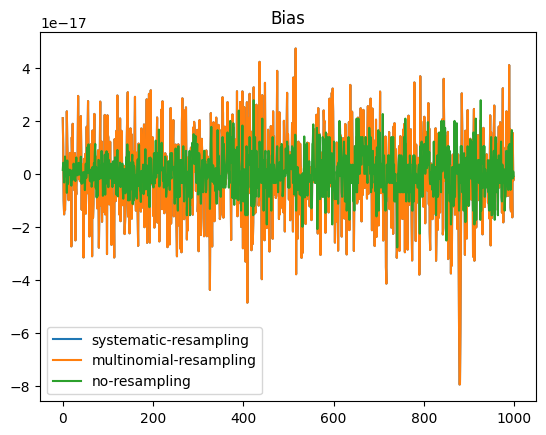

In [175]:
plt.title('Bias')
plt.plot(bias_systematic, label='systematic-resampling')
plt.plot(bias_multinomial, label='multinomial-resampling')
plt.plot(bias_no_resampling, label='no-resampling')
plt.legend()
plt.show()

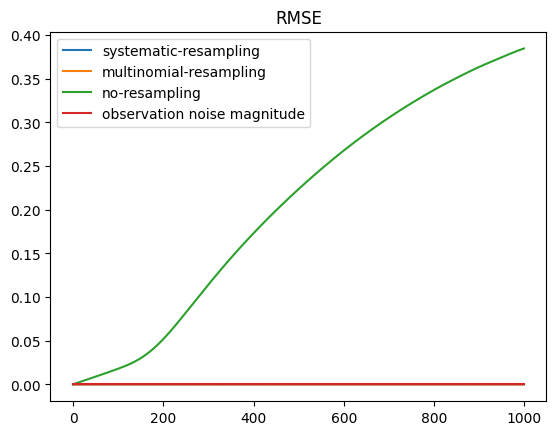

In [176]:
plt.title('RMSE')
plt.plot(rmse_systematic,label=f'systematic-resampling')
plt.plot(rmse_multinomial,label=f'multinomial-resampling')
plt.plot(rmse_no_resampling,label=f'no-resampling')
plt.plot(observation_noise*jnp.ones_like(rmse_systematic),label=f'observation noise magnitude')
plt.legend()
plt.show()

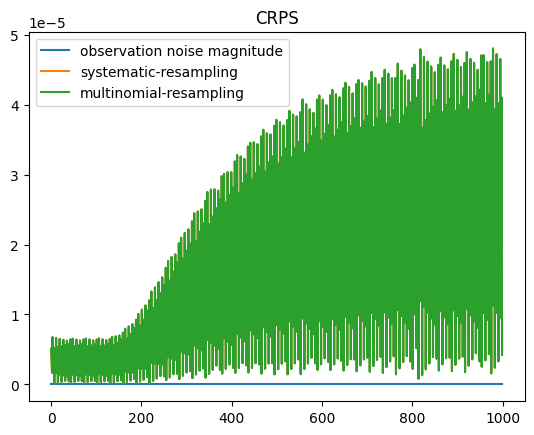

In [178]:
plt.title('CRPS')
plt.plot(observation_noise*jnp.ones_like(crps_systematic),label=f'observation noise magnitude')
plt.plot(crps_systematic,label=f'systematic-resampling')
plt.plot(crps_multinomial,label=f'multinomial-resampling')
#plt.plot(crps_no_resampling,label=f'no-resampling')
plt.legend()
plt.show()